In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks
import time

In [2]:
start = time.perf_counter()
# Parametry siatki
N = 2**9            # liczba punktów siatki - 1 w każdym kierunku
x = np.linspace(-15.5, 14.5, N)
dx = x[1] - x[0]         # krok przestrzenny
L = x.max() - x.min() # długość obszaru

# Parametry fizyczne
ħ = 1.0
m = 1
dt = 0.002         # krok czasowy
Nt = 2**18
T_max = Nt * dt       # maksymalny czas
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")
T_max

Czas działania: 0.000476 sekundy


524.288

In [3]:
start = time.perf_counter()
# Potencjał: V(x, y)
# Warunki na przedział
x_min = -4
x_max = 3

# Inicjalizacja potencjału jako tablica zer
V = np.zeros_like(x)

# Obliczam V tylko tam, gdzie x mieści się w zadanym przedziale
mask1 = x < x_min
mask2 = (x >= x_min) & (x <= x_max)
mask3 = x > x_max

V[mask1] = 70*(1 - np.exp(4+x[mask1]))
V[mask2] = -120 + 10*x[mask2]+10*x[mask2]**2
V[mask3] = 70*(1 - np.exp(3-x[mask3]))

# Początkowa funkcja falowa — funkcja Gaussa
a1 = -0.25
sigma1 = 0.15
a2 = -0.55
sigma2 = 0.2
ψ = np.exp(-(x - a1)**2 / (2 * sigma1**2)) + np.exp(-(x - a2)**2 / (2 * sigma2**2))
ψ /= np.linalg.norm(ψ)  # normalizacja

ψ0 = ψ.copy()  # zapisuję funkcję początkową do korelacji
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.000843 sekundy


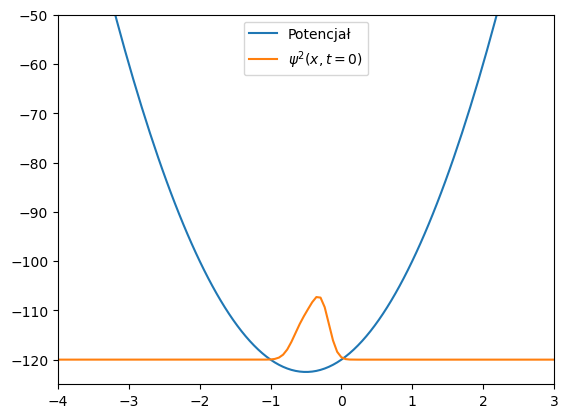

In [4]:
plt.plot(x, V, label = "Potencjał")
plt.plot(x, 100*np.abs(ψ)**2 - 120, label = "$ψ^2(x, t=0)$")
#plt.xlim(-10, 10)
#plt.ylim(-0.02, 1)
plt.xlim(-4, 3)
plt.ylim(-125, -50)
plt.legend()

In [5]:
start = time.perf_counter()
# absorber (CAP) parametry
w = 0.1 * L      # szerokość absorbera po każdej stronie
x0 = L/2 - 0.5 - w       # punkt startu tłumienia (dla prawego brzegu, lewy analogicznie)
η0 = 1.0        # maksymalny współczynnik tłumienia
alpha = 2          # potęga (2..4)

# konstrukcja η(x)
η = np.zeros_like(x)
right_mask = x > (L/2 - 0.5 - w)
η[right_mask] = η0 * ((x[right_mask] - (L/2 - 0.5 - w)) / w)**alpha
left_mask = x < -(L/2 -0.5 - w)
η[left_mask] = η0 * (((-L/2 + 0.5 + w) - x[left_mask]) / w)**alpha

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.000758 sekundy


In [6]:
start = time.perf_counter()
# FFT: przygotowanie współrzędnych pędu
kx = 2 * np.pi * fftfreq(N, dx)
K2 = kx**2

# Fazy propagacji
T_phase = np.exp(-1j * (ħ * K2 / (4 * m)) * dt)
V_phase = np.exp(-1j * V * dt / ħ)
η_phase = np.exp(- η * dt / ħ)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.000486 sekundy


In [7]:
start = time.perf_counter()
psi_t = []  # Lista funkcji falowych w kolejnych chwilach czasu

# Rejestracja g1(t)
g1_t = []

#k = 0
# Pętla czasowa
for _ in range(Nt):
    # pół krok w pędzie
    ψ_temp = fft(ψ)
    ψ_temp *= T_phase
    ψ = ifft(ψ_temp)

    # pełen krok w przestrzeni + CAP (complex absorbing potential)
    # jako warunek brzegowy absorbujący, żeby nie było interferencji
    # od ścianek siatki przestrzeni
    ψ *= V_phase
    ψ *= η_phase

    # drugi pół krok w pędzie
    ψ_temp = fft(ψ)
    ψ_temp *= T_phase
    ψ = ifft(ψ_temp)
    
    # Dodaję ψ do zbioru psi w czasie
    psi_t.append(ψ.copy())
    
    # obliczam g1(t)
    g1 = np.vdot(ψ0, ψ)
    g1_t.append(g1)

# Robienie z psi_t wektora
psi_t = np.array(psi_t)

# Czas i amplituda korelacji
t_values = np.arange(Nt) * dt
g1_t = np.array(g1_t)
amplitude = np.abs(g1_t)
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 17.373950 sekundy


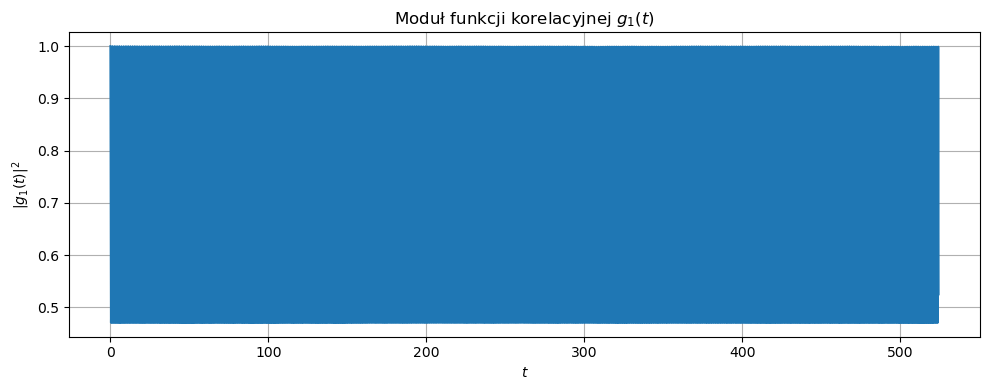

In [8]:
# Wykres
plt.figure(figsize=(10, 4))
plt.plot(t_values, amplitude**2)
plt.xlabel("$t$")
plt.ylabel(r"$|g_1(t)|^2$")
plt.title("Moduł funkcji korelacyjnej $g_1(t)$")
plt.grid(True)
plt.tight_layout()
#plt.xlim(3000,4000)
#plt.ylim(0,0.004)
plt.savefig("Studnia gładka g(t).pdf", bbox_inches='tight')
plt.show()

In [9]:
start = time.perf_counter()
# Stosuję funkcję okna do g1(t)
window = (1 - np.cos(2 * np.pi * t_values / T_max)) / T_max
#window = np.ones(len(t_values))
g1_windowed = g1_t * window

# Transformata Fouriera z oknem
g1_E = fft(g1_windowed)
freqs = fftfreq(Nt, dt)  # jednostki częstotliwości
E = 2 * np.pi * freqs * ħ  # przekształcenie na energię

# Przesuwam energie i funkcje korelacji
E = np.fft.fftshift(E)
g1_E = np.fft.fftshift(g1_E)
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.045712 sekundy


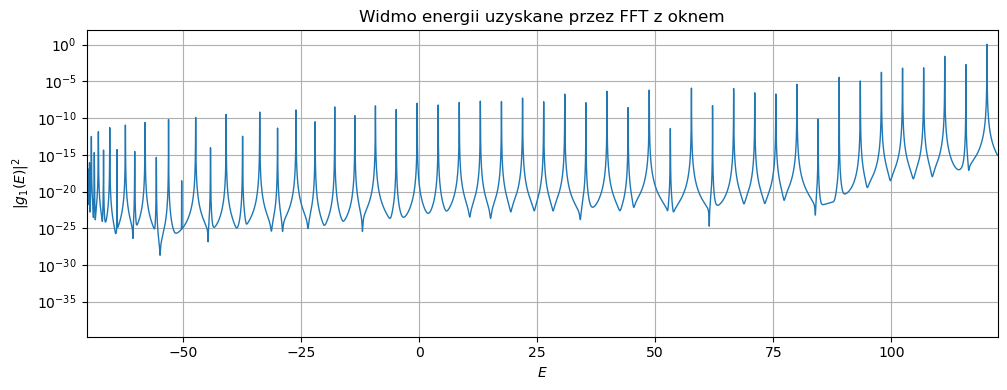

In [10]:
# Wykres widma
plt.figure(figsize=(10, 4))
plt.plot(E, np.abs(g1_E)**2 * 2 / len(g1_E), lw=1)
plt.xlim(-70.5, 122.5)
plt.xlabel("$E$")
plt.ylabel(r"$|g_1(E)|^2$")
plt.title("Widmo energii uzyskane przez FFT z oknem")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.savefig("Studnia gładka g(E) 1.pdf", bbox_inches='tight')
plt.show()

In [11]:
start = time.perf_counter()
# Przepisuję g1_E do zręczniejszej postaci i ustawiam próg dla maksimów
g1_E_temp = (np.abs(g1_E)**2 * 2 / len(g1_E))
threshold = np.max(g1_E_temp) * 0


'''
# Wcześniejszy kod na poszukiwanie pików

# Szukam lokalnych maksimów: sprawdzam czy sąsiednie punkty są < od tego, który sprawdzamy + dodatkowo czy sprawdzany punkt nie jest > od progu (threshold)
peaks = (g1_E_temp[1:-1] > g1_E_temp[:-2]) & (g1_E_temp[1:-1] > g1_E_temp[2:]) & (g1_E_temp[1:-1] > threshold)
peak_indices = np.where(peaks)[0] + 1
peak_energies = E[peak_indices]
peak_amplitudes = g1_E_temp[peak_indices]
'''

# Szukam lokalnych maksimów
peak_indices_0, _ = find_peaks(np.abs(g1_E), height=threshold, prominence=0.0000000000001)
peak_indices = []

for idx in peak_indices_0:
    if E[idx] > -69.967:
        peak_indices.append(idx)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 1.276697 sekundy


In [12]:
E[peak_indices]

array([-69.8680312 , -69.47255178, -68.84937208, -67.98650789,
       -66.89594342, -65.57767868, -64.03171367, -62.27003261,
       -60.2926355 , -58.09952234, -55.71466159, -53.12606901,
       -50.34572883, -47.37364105, -44.23377413, -40.92612805,
       -37.4387186 , -33.80749846, -30.03246761, -26.12561029,
       -22.0869265 , -17.91641623, -13.65003217,  -9.29975853,
        -4.88956376,  -0.45540055,   4.00273112,   8.46086278,
        12.93097867,  17.40109456,  21.87121045,  26.35331057,
        30.82342646,  35.29354235,  39.76365824,  44.23377413,
        48.70389002,  53.18599013,  57.65610602,  62.12622191,
        66.5963378 ,  71.06645369,  75.53656958,  80.01866969,
        84.48878558,  88.95890147,  93.42901736,  97.89913325,
       102.38123337, 106.85134926, 111.32146515, 115.79158104,
       120.26169693])

In [ ]:
start = time.perf_counter()

def Gamma1(delta):
    # Funkcja Gamma
    return np.where(np.isclose(delta, 0), 1.0, (np.exp(2j * np.pi * delta) - 1) / (2j * np.pi * delta))

def Phi1(delta):
    # Funkcja Phi
    return Gamma1(delta) - 0.5 * (Gamma1(delta + 1) + Gamma1(delta - 1))

def choosing_delta_prime_from_R(R, T):
    # Funkcja, która wybiera deltę (== przesrunięcie wartości własnej E_n
    # z przyczyny tego, że mamy siatkę tylko z N_t elementów).
    # Korzystam z tej funkcji, bo w artkule Feita, Flecka i Steigera
    # dla wyboru δ' porównujemy R z 1, ale w obliczeniach mamy
    # R zespolone => nie możemy robić operacje < lub > z R.
    # Tu wybór się bazuje na 1) czy |δ'| < 1, 2) chcęmy δ' o mniejszej
    # części urojonej, bo energie są rzeczywistymi, 3) R, które mamy z
    # funkcji korelacji g_1(E), musi być bliskie do Phi(δ') dla
    # odpowiedniej δ'.
    
    # obliczam r = (1+R)/(1-R)
    r = (1 + R) / (1 - R)

    # rozwiązuję równanie kwadratowe δ'^2 - 3 r δ' + 2 = 0
    # δ'_{1,2} = (3r ± sqrt(9 r^2 - 8)) / 2
    discriminant = np.sqrt(9 * r**2 - 8)
    cand1 = (-3 * r + discriminant) / 2
    cand2 = (-3 * r - discriminant) / 2

    candidates = [cand1, cand2]

    # kryteria wyboru:
    best = None
    best_score = None
    for cand in candidates:
        # kryterium 1: czy realna część δ' leży w (-1, 1),
        # bo zakładamy, że jesteśmy blisko E_n
        in_range = np.abs(cand.real) < 1.0

        # kryterium 2: jak duża część urojona δ' (mniejsza => lepiej)
        imag_mag = np.abs(cand.imag)

        # kryterium 3: residual względem rzeczywistego R
        R_model = Phi1(cand + 1) / Phi1(cand - 1)
        residual = np.abs(R_model - R)

        # scoring: najpierw in_range, potem małe imag, potem mały residual
        # im mniejszy score, tym lepiej. Dlatego układamy odpowiednią ważność
        # kryteriów: 1), 3), 2)
        score = (0 if in_range else 1) + 1e-6 * imag_mag + 1e-9 * residual
        
        if (best is None) or (score < best_score):
            best = cand
            best_score = score

    # zwracam najlepsze δ'
    return best

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

In [13]:
start = time.perf_counter()

def compute_En_Wn(E, g1_E, m, T):
    # Funkcja dopasowania z pomocą lineshape fitting
    
    E_m = E[m]

    # zabezpieczenie brzegowe
    if m <= 0 or m >= len(E) - 1:
        return None

    g1_plus = g1_E[m + 1]
    g1_minus = g1_E[m - 1]
    g1_middle = g1_E[m]

    R = g1_plus / g1_minus

    delta_p = choosing_delta_prime_from_R(R, T)
    
#    r = (1 + R) / (1 - R)
#    discriminant = 9 * r**2 - 8
#    if np.real(discriminant) < 0:
#        return None  # nie ma pierwiastka rzeczywistego, pomijam

#    sqrt_term = np.sqrt(discriminant)

    
    
#    if np.abs(R) < 1:
#        delta_p = (-3 * r + sqrt_term) / 2
#    else:
#        delta_p = (-3 * r - sqrt_term) / 2

    E_n = E_m - (2 * np.pi * delta_p) / T
    phi = Phi1(delta_p)
    W_n = g1_middle / phi

    return E_n, W_n, delta_p, R

# Lista wyników
results = []

for m in peak_indices:
    res = compute_En_Wn(E, g1_E, m, T_max)
    if res is not None:
        E_n, W_n, delta_p, R = res
        results.append({
            'E_n': E_n.real,
            'W_n_abs': np.abs(W_n),
            'W_n_phase': np.angle(W_n),
            'delta_p': delta_p,
            'R': R
        })

# Sortowanie według energii

#results = [r for r in results if r['E_n'] >= -5]
for r in results: r['E_n'] *= -1
    
results.sort(key=lambda x: x['E_n'])

# Wyświetlenie wyników
print(f"{'E_n [a.u.]':>12} | {'|W_n|':>12} | {'arg(W_n) [rad]':>14} | {'δ′':>8}")
print(" " + "-" * 66)
for r in results:
    print(f"{(r['E_n']):12.6f} | {r['W_n_abs']:12.6e} | {r['W_n_phase']:14.6f} | {r['delta_p'].real:8.3f}")

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

  E_n [a.u.] |        |W_n| | arg(W_n) [rad] |       δ′
 ------------------------------------------------------------------
 -120.259469 | 3.925742e+02 |       0.240528 |    0.186
 -115.791388 | 1.592716e+01 |       0.231584 |    0.016
 -111.323307 | 5.898617e+01 |       0.222639 |   -0.154
 -106.855227 | 1.018524e+01 |       0.213695 |   -0.324
 -102.387146 | 1.057783e+01 |       0.204751 |   -0.493
  -97.895096 | 5.092168e+00 |       0.195806 |    0.337
  -93.427015 | 1.238716e+00 |       0.186862 |    0.167
  -88.958934 | 2.167521e+00 |       0.177918 |   -0.003
  -84.490853 | 3.208417e-03 |       0.168972 |   -0.173
  -80.022773 | 7.688623e-01 |       0.160029 |   -0.342
  -75.530723 | 1.855180e-01 |       0.151085 |    0.488
  -71.062642 | 2.029696e-01 |       0.142141 |    0.318
  -66.594561 | 3.758274e-01 |       0.133196 |    0.148
  -62.126480 | 2.558002e-02 |       0.124252 |   -0.022
  -57.658400 | 4.040441e-01 |       0.115308 |   -0.191
  -53.190319 | 7.705212e-04 |       

In [58]:
len(results)

53

In [15]:
energies = np.array([r["E_n"] for r in results])

In [16]:
np.save("energie własne E dla gładkiej studni 1D SM.npy", energies)

In [59]:
start = time.perf_counter()
# Stosujemy okno czasowe Hann jak wcześniej
psi_t_windowed = psi_t * window[:, np.newaxis]

# FFT po czasie, dla każdego x
psi_E = fft(psi_t_windowed, axis=0)  # shape: (Nt, Nx)

psi_E = np.fft.fftshift(psi_E, axes=0)  # Przesunięcie zerowej częstotliwości na środek

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 6.734626 sekundy


In [60]:
start = time.perf_counter()
eigen_psi = []

for r in results:
    # Znajduję najbliższy indeks na osi energii
    idx = np.argmin(np.abs(E + r['E_n']))
    psi_n = psi_E[idx, :]  # Funkcja falowa dla En (do normowania)
    eigen_psi.append(psi_n)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.337296 sekundy


In [61]:
start = time.perf_counter()
eigen_psi_norm = [ψn / np.linalg.norm(ψn) for ψn in eigen_psi]
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.002307 sekundy


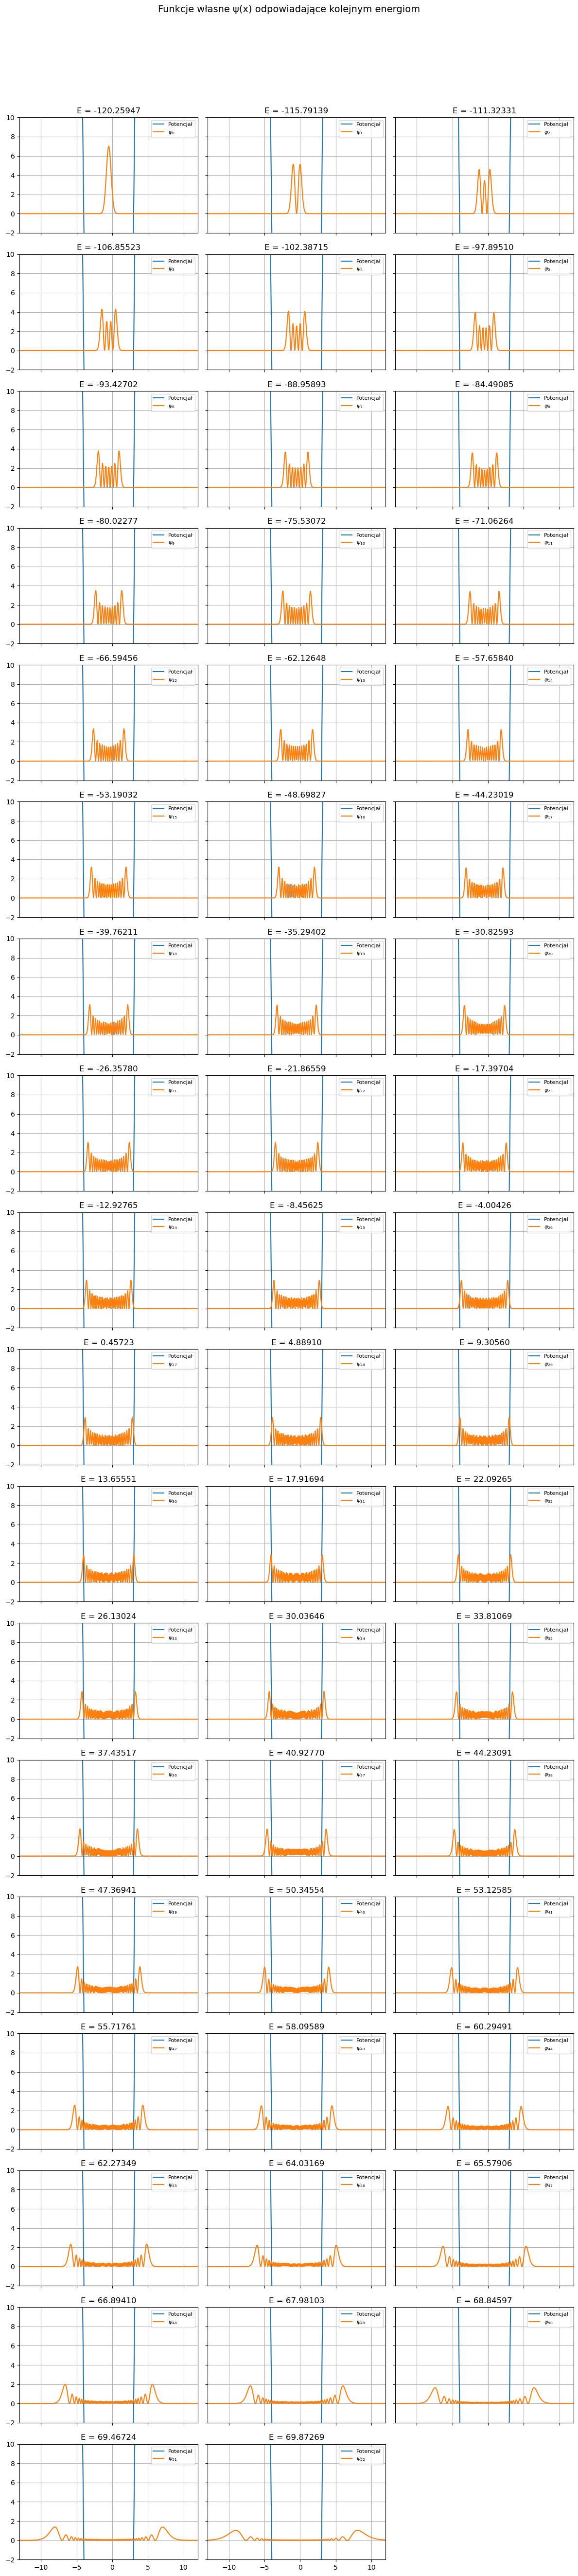

In [62]:
num_states = len(eigen_psi_norm)
cols = 3
rows = (num_states + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, ψn in enumerate(eigen_psi_norm):
    ax = axes[i]
    ax.plot(x, V, label = "Potencjał")
    ax.plot(x, 100*np.abs(ψn)**2, label=r"$\psi_{%d}$" % i)
    ax.set_title(f"E = {(results[i]['E_n']):.5f}")
    ax.grid(True)
    ax.legend(fontsize=8)
    ax.set_xlim(-13, 12)
    ax.set_ylim(-2, 10)

# Jeśli są puste komórki, wyłącz je
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Funkcje własne ψ(x) odpowiadające kolejnym energiom", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [63]:
np.save("funkcje psi(E) dla gładkiej studni 1D SM.npy", eigen_psi_norm)

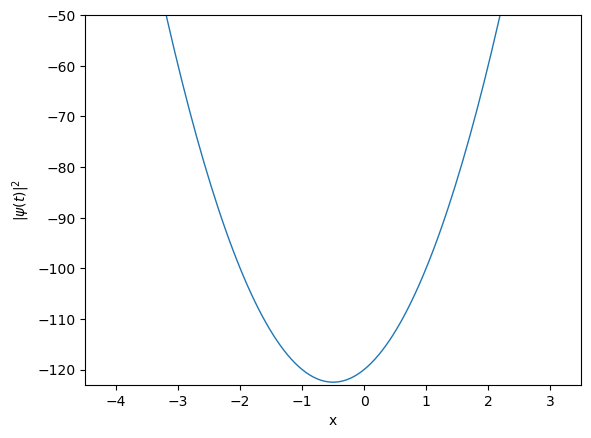

In [11]:
fig, ax = plt.subplots()

line_V, = ax.plot(x, V, lw=1,  label="V(x)")
line, = ax.plot([], [], lw=2)

ax.set_xlim(-4.5, 3.5)
ax.set_ylim(-123, -50)

ax.set_xlabel("x")
ax.set_ylabel("$|ψ(t)|^2$")
plt.show()

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = 200*np.abs(psi_t[frame])**2 - 100
    line.set_data(x, y)
    ax.set_title(f"t = {t_values[frame]:.2f}")
    return line,

ani = animation.FuncAnimation(fig, update, frames = range(0, Nt // 2**7, 13), init_func=init, blit=True)

In [12]:
# Robię filmik ewolucji funkcji w czasie

import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl

mpl.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=2800)
ani.save("studnia gładka.mp4", writer=writer)